In [1]:
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pickle
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

In [2]:
os.chdir('../')

In [3]:
import params
import make_dictionaries

source_directory = params.source_directory
full_sample = 'full_sample_debiased.fits'

In [4]:
questions = make_dictionaries.questions
print('Loaded questions...')
function_dictionary = make_dictionaries.function_dictionary
print('Loaded functions...')

Loaded questions...
Loaded functions...


In [5]:
colors = ['r','b','g','y']
colors_long = ['orange','r','magenta','g','blue','cyan','k']

In [6]:
debiased_data = Table.read('../fits/' + full_sample)
print('Loaded galaxy data...')
in_volume_limit = debiased_data['in_volume_limit'] == True
in_mass_limit = debiased_data['LOGMSTAR_BALDRY06'] > 10.6
vl_data = debiased_data[(in_volume_limit)]
ml_data = debiased_data[(in_volume_limit) & (in_mass_limit)]

Loaded galaxy data...


In [7]:
def reduce_sample(full_data,questions,question,p_cut=0.5,N_cut=5,normalised_values=True):
    
    # Get the reference sample from the previous data:
    
    previous_q = questions[question]['pre_questions']
    previous_a = questions[question]['pre_answers']
    
    if normalised_values == True:
        suffix = '_debiased_rh_normalised'
    else:
        suffix = '_debiased_rh'
    
    if previous_q != None:
        
        p_col = np.ones(len(full_data))
        
        for m in range(len(previous_q)):
            p_col = p_col*(full_data[previous_q[m] + '_' + previous_a[m] + suffix])
        N_col = (full_data[previous_q[-1] + '_' + previous_a[-1] + '_count'])
        
        select = (p_col > p_cut) & (N_col >= N_cut)
        data_reduced = full_data[select]
        print('{}/{} galaxies with p>{} and N>={}.'.format(len(data_reduced),
                                                          len(full_data),p_cut,N_cut))
    
    else:
        data_reduced = full_data.copy()
        select = np.ones(len(full_data)) == 1
        print('Primary question, so all {} galaxies used.'.format(len(data_reduced)))
    
    return data_reduced,select


def get_spirals_and_assignments(full_data,question_dictionary,th=None):
    
    data,select = reduce_sample(full_data,question_dictionary,'t11_arms_number')
    
    answers = question_dictionary['t11_arms_number']['answers']

    remove_ct = data['t04_spiral_a08_spiral_count'] - data['t11_arms_number_a37_cant_tell_count'] >= 5
    # remove any gals where most votes are for can't tell
    in_volume_limit = data['in_volume_limit'] == 1
    
    spirals = data[(remove_ct) & (in_volume_limit)]
    print('{} galaxies with p>0.5 and N>=5'.format(len(spirals)))
    
    arm_answers = ['t11_arms_number_' + A + '_debiased_rh' for A in answers[:-1]]
    arm_array = np.array([spirals[A] for A in arm_answers]).T
    raw_answers = ['t11_arms_number_' + A + '_weighted_fraction' for A in answers[:-1]]
    raw_array = np.array([spirals[A] for A in raw_answers]).T
    
    if th != None:
        select = np.max(arm_array,axis=1) > th
    else:
        select = np.ones(len(spirals)) == 1
    
    arm_assignments = np.argmax(arm_array,axis=1)
    raw_assignments = np.argmax(raw_array,axis=1)
    
    arm_assignments = arm_assignments[select]
    raw_assignmnets = raw_assignments[select]
    spirals = spirals[select]
    redshifts = spirals['REDSHIFT_1']
    
    return spirals,arm_assignments

In [8]:
vl_spirals,vl_assignments = get_spirals_and_assignments(vl_data,questions)
ml_spirals,ml_assignments = get_spirals_and_assignments(ml_data,questions)

21591/62220 galaxies with p>0.5 and N>=5.
17953 galaxies with p>0.5 and N>=5
11218/41801 galaxies with p>0.5 and N>=5.
9389 galaxies with p>0.5 and N>=5


In [9]:
def get_column(data,column_name):
    
    if len(column_name) == 2:
        column = data[column_name[0]] - data[column_name[1]]
    else:
        column = data[column_name]
        
    return column

In [10]:
def histograms(data,assignments,axarr,bins,column_name,
               reference_data=None,linestyle='solid',linewidth=3,ref_col='k',
               mean_lines=False,ylims=None):
    
    labels = questions['t11_arms_number']['answerlabels']
    
    for m,ax in enumerate(axarr):
        
        if reference_data != None:
            ref = get_column(reference_data,column_name)
            _ = ax.hist(ref,bins,histtype='stepfilled',alpha=0.3,
                        color=ref_col,normed=True)
        
        if data != None:
            data_m = get_column(data[assignments == m],column_name)
            _ = ax.hist(data_m,bins,histtype='step',linestyle=linestyle,
                        color=colors_long[m],linewidth=linewidth,normed=True)
            
        if mean_lines == True:
            #yl = plt.gca().get_ylim()
            ax.vlines(np.mean(data_m),ylims[0],ylims[1],color=colors_long[m],
                       linewidth=2,linestyle='dashed')
            ax.vlines(np.mean(data_m)-np.std(data_m),ylims[0],ylims[1],color=colors_long[m],
                       linewidth=2,linestyle='dashed')
            ax.vlines(np.mean(data_m)+np.std(data_m),ylims[0],ylims[1],color=colors_long[m],
                       linewidth=2,linestyle='dashed')
        
        ax.set_ylabel('$f_\mathrm{normalised}$')
        ax.text(0.975,0.9,'m={} ({} galaxies)'.format(labels[m],len(data_m))
                ,transform=ax.transAxes,ha='right',va='top')
        
    return fig,axarr


def lines(data,assignments,axarr,column_name,nbins=20):
    
    labels = questions['t11_arms_number']['answerlabels']
    
    column = get_column(data,column_name)
    z,bins = bin_by_column(column,nbins)

    for m,ax in enumerate(axarr):
        
        column_m = column[assignments == m]
        
        fracs = get_arm_fraction(assignments,bins,m)
        axarr[m].plot(z,fracs['f'],linewidth=2,linestyle='solid',color=colors_long[m])
        axarr[m].fill_between(z,fracs['low_f'],fracs['high_f'],color=colors_long[m],alpha=0.5)

        ax.set_ylabel('$f_\mathrm{{m=' + '{}'.format(labels[m]) + '}}$')
        
    return fig,axarr


def print_tables(data,assignments,column_name,nbins=20):
    
    labels = questions['t11_arms_number']['answerlabels']
    
    column = get_column(data,column_name)
    z,bins = bin_by_column(column,nbins)
    
    print('{}-------')
    for b in np.unique(bins):
        column_b = column[bins == b]
        print(np.mean(column_b),np.std(column_b))

    for m in range(5):
        
        column_m = column[assignments == m]
        
        fracs = get_arm_fraction(assignments,bins,m)
        means = get_arm_fraction(assignments,np.zeros(len(column)),m)
        
        print('{}------'.format(labels[m]))
        print(fracs)
        print(means)
        
    return None

In [11]:
from scipy.stats import binned_statistic
import scipy.stats.distributions as dist

def get_arm_fraction(column,bins,m):
    
    N_b = len(np.unique(bins))
    fractions = np.zeros(N_b)
    upper_fracs = np.zeros(N_b)
    lower_fracs = np.zeros(N_b)
    
    for n,b in enumerate(np.unique(bins)):
        
        bin_col = column[bins == b]
        bin_m = np.sum(bin_col == m)
        bin_tot = len(bin_col)
        
        f_low,f_high = get_fractional_errors(bin_m,bin_tot)
        fractions[n] = bin_m/bin_tot
        lower_fracs[n] = f_low
        upper_fracs[n] = f_high
    
    fractions_table = Table(np.array([lower_fracs,fractions,upper_fracs]).T
                            ,names=('low_f','f','high_f'))
    
    return fractions_table


def get_fractional_errors(k,n,c=0.683):
    
    p_lower = dist.beta.ppf((1-c)/2.,k+1,n-k+1)
    p_upper = dist.beta.ppf(1-(1-c)/2.,k+1,n-k+1)
    
    return p_lower,p_upper


def bin_by_column(column, nbins, fixedcount=True):
    sorted_indices = np.argsort(column)
    if fixedcount:
        bin_edges = np.linspace(0, 1, nbins + 1)
        bin_edges[-1] += 1
        values = np.empty(len(column))
        values[sorted_indices] = np.linspace(0, 1, len(column))
        bins = np.digitize(values, bins=bin_edges)
    else:
        bin_edges = np.linspace(np.min(column),np.max(column), nbins + 1)
        bin_edges[-1] += 1
        values = column
        bins = np.digitize(values, bins=bin_edges)
    x, b, n = binned_statistic(values, column, bins=bin_edges)
    return x, bins

# Environment

Plot of local environment from Baldry et al.

/home/ppxrh/anaconda3/lib/python3.4/site-packages/astropy/table/table.py:1821: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  result = self._data == other


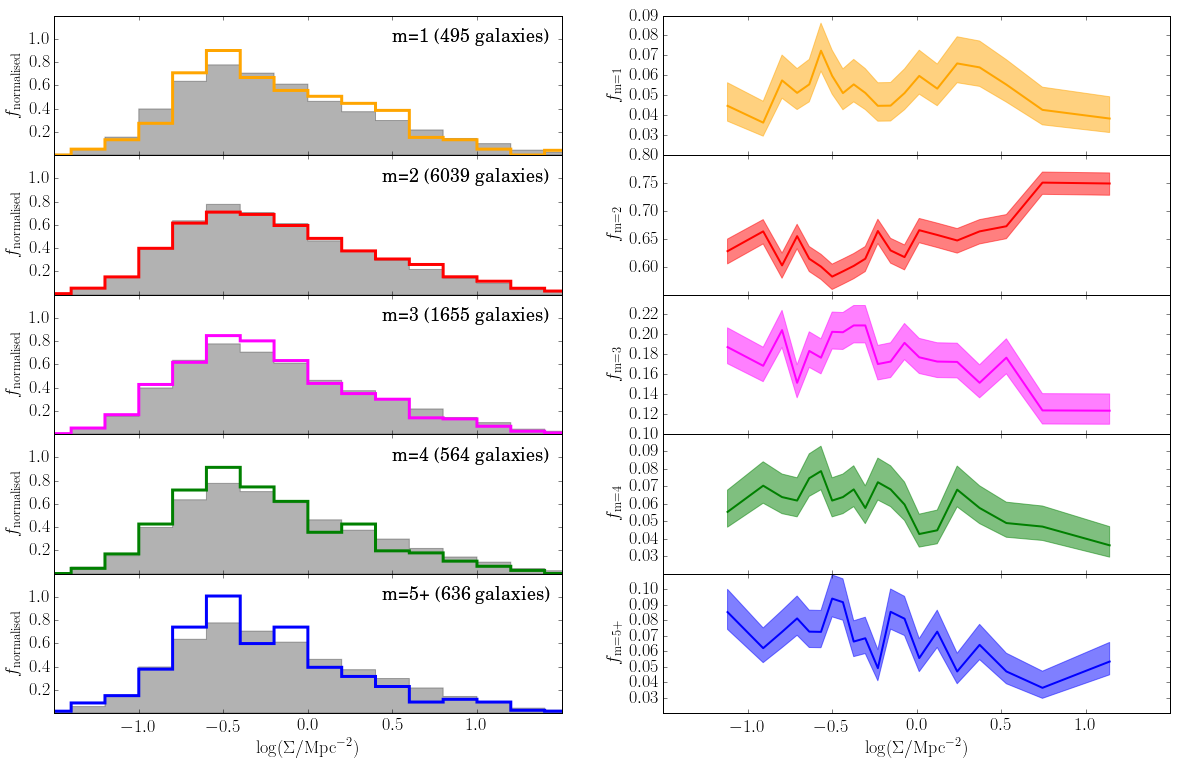

In [12]:
fig,axarr = plt.subplots(5,2,figsize=(20,12.5),sharex=True,sharey=False)
plt.subplots_adjust(hspace=0,wspace=0.2)

axarr1 = axarr[:,0]
axarr2 = axarr[:,1]

for ax in axarr[-1]:
    ax.set_xlabel('$\log (\Sigma / \mathrm{Mpc^{-2}})$')

histograms(ml_spirals,ml_assignments,axarr1,np.linspace(-2,2,21),'IVAN_DENSITY',
           reference_data=ml_spirals)

lines(ml_spirals,ml_assignments,axarr2,'IVAN_DENSITY',nbins=20)

axarr = axarr.ravel()
for ax in axarr:
    ax.set_xlim(-1.5,1.5)

for ax in axarr1:
    ax.set_ylim(0,1.2)
    
#axarr1[2].set_ylabel('normalised fraction')
#axarr2[2].set_ylabel('fraction')

#plt.savefig('Plotting_codes/figures/density_plots.pdf')

In [13]:
print_tables(ml_spirals,ml_assignments,'IVAN_DENSITY')

{}-------
-1.11811 0.121443
-0.907241 0.035329
-0.795696 0.0280981
-0.706606 0.0229945
-0.63484 0.0206604
-0.565422 0.018956
-0.499371 0.0171347
-0.435692 0.0183971
-0.371775 0.0195864
-0.303508 0.0205993
-0.229012 0.0217801
-0.153765 0.0224652
-0.0714079 0.02599
0.015626 0.0264592
0.122061 0.0333004
0.240088 0.0364351
0.372675 0.0421287
0.53093 0.051948
0.744364 0.0743261
1.14164 0.212928
1------
     low_f             f             high_f    
--------------- --------------- ---------------
0.0369667646534 0.0446808510638 0.0562579754372
0.0294521346557 0.0362473347548  0.046985779085
 0.048497454805 0.0574468085106 0.0701506188309
0.0428021657277 0.0511727078891  0.063359142486
0.0466638457445 0.0554371002132 0.0679899084426
0.0621313621612 0.0723404255319 0.0861774019228
0.0505424081307 0.0597014925373 0.0726038050991
0.0427108953094 0.0510638297872 0.0632254928719
0.0466638457445 0.0554371002132 0.0679899084426
0.0428021657277 0.0511727078891  0.063359142486
0.0369667646534 0.04468

# Stellar mass 

Stellar mass distributions from Baldry et al.

In [ ]:
fig,axarr = plt.subplots(5,2,figsize=(20,12.5),sharex=False,sharey=False)
plt.subplots_adjust(hspace=0,wspace=0.2)

axarr1 = axarr[:,0]
axarr2 = axarr[:,1]

for ax in axarr[-1]:
    ax.set_xlabel('$\log(M_*/M_{\odot})$')

histograms(vl_spirals,vl_assignments,axarr1,np.linspace(9.8,11.4,17),'LOGMSTAR_BALDRY06',
           reference_data=vl_spirals)

lines(ml_spirals,ml_assignments,axarr2,'LOGMSTAR_BALDRY06',nbins=20)

axarr = axarr.ravel()
for ax in axarr2:
    ax.set_xlim(10.55,11.25)
for ax in axarr1:
    ax.set_xlim(9.8,11.4)
    ax.set_ylim(0,1.8)

for ax in axarr1:
    ax.vlines(10.6,0,1.8,linewidth=4,color='k',linestyle='dotted')
    
#axarr1[2].set_ylabel('normalised fraction')
#axarr2[2].set_ylabel('fraction')

plt.savefig('Plotting_codes/figures/mass_plots.pdf')

In [ ]:
print_tables(ml_spirals,ml_assignments,'LOGMSTAR_BALDRY06')

# Star formation rates

These are the sSFR plots. However, I don't think we will use them, as they use small apertures etc., probably raises more questions than answers

In [ ]:
fig,axarr = plt.subplots(5,1,figsize=(10,12.5))
plt.subplots_adjust(hspace=0,wspace=0)

#axarr[-1].set_xlabel('$\log(M_*/M_{\odot})$')
axarr[-1].set_xlabel('sSFR $(\log(M_{\odot}M_*^{-1}yr^{-1}))$')

histograms(ml_spirals,ml_assignments,axarr,np.linspace(-12.5,-9.5,31),'ssfr_total_avg',
           reference_data=ml_data)

plt.savefig('Plotting_codes/figures/sfr_histograms.pdf')

# Galaxy colours

In [ ]:
fig,axarr = plt.subplots(5,2,figsize=(20,12.5),sharex=False,sharey=False)
plt.subplots_adjust(hspace=0,wspace=0.2)

axarr1 = axarr[:,0]
axarr2 = axarr[:,1]

for ax in axarr[-1]:
    ax.set_xlabel('$g-r$')

histograms(ml_spirals,ml_assignments,axarr1,np.linspace(0.3,0.9,31),['PETROMAG_MG','PETROMAG_MR'],
           reference_data=ml_spirals,mean_lines=True,ylims=[0,8])

lines(ml_spirals,ml_assignments,axarr2,['PETROMAG_MG','PETROMAG_MR'],nbins=20)

for ax in axarr2:
    ax.set_xlim(0.45,0.85)
for ax in axarr1:
    ax.set_xlim(0.35,0.85)
    ax.set_ylim(0,8)

plt.savefig('Plotting_codes/figures/colour_plots.pdf')

In [ ]:
print_tables(ml_spirals,ml_assignments,['PETROMAG_MG','PETROMAG_MR'])

# Table

Table of data values

In [14]:
def reduce_sample(full_data,questions,question,p_cut=0.5,N_cut=5,suffix='_weighted_fraction'):
    
    # Get the reference sample from the previous data:
    
    previous_q = questions[question]['pre_questions']
    previous_a = questions[question]['pre_answers']
    
    if previous_q != None:
        
        p_col = np.ones(len(full_data))
        
        for m in range(len(previous_q)):
            p_col = p_col*(full_data[previous_q[m] + '_' + previous_a[m] + suffix])
        N_col = (full_data[previous_q[-1] + '_' + previous_a[-1] + '_count'])
        
        select = (p_col > p_cut) & (N_col >= N_cut)
        data_reduced = full_data[select]
        print('{}/{} galaxies with p>{} and N>={}.'.format(len(data_reduced),
                                                          len(full_data),p_cut,N_cut))
    
    else:
        data_reduced = full_data.copy()
        select = np.ones(len(full_data)) == 1
        print('Primary question, so all {} galaxies used.'.format(len(data_reduced)))
    
    return data_reduced,select


def get_spirals_and_assignments(full_data,question_dictionary,th=None,suffix='_weighted_fraction'):
    
    data,select = reduce_sample(full_data,question_dictionary,'t11_arms_number',suffix=suffix)
    
    answers = question_dictionary['t11_arms_number']['answers']

    remove_ct = data['t04_spiral_a08_spiral_count'] - data['t11_arms_number_a37_cant_tell_count'] >= 5
    # remove any gals where most votes are for can't tell
    in_volume_limit = data['in_volume_limit'] == 1
    
    spirals = data[(remove_ct) & (in_volume_limit)]
    print('{} galaxies with p>0.5 and N>=5'.format(len(spirals)))
    
    arm_answers = ['t11_arms_number_' + A + suffix for A in answers[:-1]]
    arm_array = np.array([spirals[A] for A in arm_answers]).T
    
    if th != None:
        select = np.max(arm_array,axis=1) > th
    else:
        select = np.ones(len(spirals)) == 1
    
    arm_assignments = np.argmax(arm_array,axis=1)
    
    arm_assignments = arm_assignments[select]
    spirals = spirals[select]
    redshifts = spirals['REDSHIFT_1']
    
    return spirals,arm_assignments

def get_vl_ml(D,Q,suffix):
    
    vl,vl_a = get_spirals_and_assignments(D,Q,suffix=suffix)
    select = vl['LOGMSTAR_BALDRY06'] > 10.6
    ml = vl[select]
    ml_a = vl_a[select]
    
    return vl,vl_a,ml,ml_a

In [15]:
vl_raw,vl_raw_a,ml_raw,ml_raw_a = get_vl_ml(debiased_data,questions,'_weighted_fraction')
vl_w13,vl_w13_a,ml_w13,ml_w13_a = get_vl_ml(debiased_data,questions,'_debiased')
vl_h16,vl_h16_a,ml_h16,ml_h16_a = get_vl_ml(debiased_data,questions,'_debiased_rh_normalised')

28962/228201 galaxies with p>0.5 and N>=5.
12554 galaxies with p>0.5 and N>=5
41413/228201 galaxies with p>0.5 and N>=5.
14297 galaxies with p>0.5 and N>=5
58679/228201 galaxies with p>0.5 and N>=5.
17953 galaxies with p>0.5 and N>=5


In [20]:
from tabulate import tabulate

# make lists of properties:
index = ['Luminosity-limited']
m = ['1','2','3','4','5+']
index.extend(m)
index.append('Stellar mass-limited')
index.extend(m)

mass = []
color = []
density = []

def append(list,column,type='float',error=True):
    
    mean_value = np.mean(column)
    std_value = np.std(column)
    
    if error == False:
        list.append('${0:.2f}$'.format(mean_value)) 
    else:
        list.append('${0:.2f}'.format(mean_value) 
                    + ' ({0:.2f})$'.format(std_value))
    
    return list


def append_sample_sizes(samples=[vl_raw,ml_raw],arms=[vl_raw_a,ml_raw_a]):
    
    N = []
    f = []
    
    for s,sample in enumerate(samples):
        m_vals = arms[s]
        N.append('${}$'.format(len(sample)))
        f.append('$1.00$')
        
        for m in range(5):
            m_sample = sample[m_vals == m]
            N.append('${}$'.format(len(m_sample)))
            f.append('${0:.2f}$'.format(len(m_sample)/len(sample)))
        
    return N,f

In [21]:
# Append demographics lists: -----
arms = [vl_h16_a,ml_h16_a]
for s,sample in enumerate([vl_h16,ml_h16]):
    
    arm_assignments = arms[s]
    
    mass = append(mass,sample['LOGMSTAR_BALDRY06'])
    color = append(color,sample['PETROMAG_MG']-sample['PETROMAG_MR'])
    density = append(density,sample['LOGMSTAR_BALDRY06'])
    
    for m in range(5):
        
        m_sample = sample[arm_assignments == m]
        
        mass = append(mass,m_sample['LOGMSTAR_BALDRY06'])
        color = append(color,m_sample['PETROMAG_MG']-m_sample['PETROMAG_MR'])
        density = append(density,m_sample['LOGMSTAR_BALDRY06'])
#----------------------------------

N_raw,f_raw = append_sample_sizes([vl_raw,ml_raw],[vl_raw_a,ml_raw_a])
N_w13,f_w13 = append_sample_sizes([vl_w13,ml_w13],[vl_w13_a,ml_w13_a])
N_h16,f_h16 = append_sample_sizes([vl_h16,ml_h16],[vl_h16_a,ml_h16_a])

In [22]:
table = np.array([index
                  ,N_raw,f_raw
                  ,N_w13,f_w13
                  ,N_h16,f_h16
                  ,mass,color,density]).T
headers = [r'm',
           r'N_{raw}',r'f_{raw}',
           r'N_{W13}',r'f_{W13}',
           r'N_{debiased}',r'f_{debiased}',
           r'Stellar mass (\log(M/M_{\odot}))',r'g-r',r'\Sigma \textrm{(Mpc^{-2})}']

In [23]:
print(tabulate(table,headers,tablefmt='latex'))

\begin{tabular}{llllllllll}
\hline
 m                    & N\_\{raw\}   & f\_\{raw\}   & N\_\{W13\}   & f\_\{W13\}   & N\_\{debiased\}   & f\_\{debiased\}   & Stellar mass (\textbackslash{}log(M/M\_\{\textbackslash{}odot\}))   & g-r           & \textbackslash{}Sigma \textbackslash{}textrm\{(Mpc\^{}\{-2\})\}   \\
\hline
 Luminosity-limited   & \$12554\$   & \$1.00\$    & \$14297\$   & \$1.00\$    & \$17953\$        & \$1.00\$         & \$10.62 (0.25)\$                     & \$0.58 (0.10)\$ & \$10.62 (0.25)\$               \\
 1                    & \$563\$     & \$0.04\$    & \$670\$     & \$0.05\$    & \$922\$          & \$0.05\$         & \$10.63 (0.27)\$                     & \$0.58 (0.11)\$ & \$10.63 (0.27)\$               \\
 2                    & \$9044\$    & \$0.72\$    & \$10073\$   & \$0.70\$    & \$11150\$        & \$0.62\$         & \$10.63 (0.24)\$                     & \$0.60 (0.10)\$ & \$10.63 (0.24)\$               \\
 3                    & \$1778\$    & \$0.14\$    & 

In [ ]:
vl_3 = vl_spirals[vl_assignments == 2]

vl_3.colnames

cols = ['dr7objid_1',
        't11_arms_number_a33_3_weighted_fraction',
        't11_arms_number_a33_3_debiased',
        't11_arms_number_a33_3_debiased_rh',
        'jpeg_url']

vl_3_reduced = [vl_3[c] for c in cols]
vl_3_reduced = Table(vl_3_reduced,names=('dr7_id','p3_weighted_fraction','p3_debiased_w13','p3_debiased_rh','jpeg_url'))

Table.write(vl_3_reduced,'../fits/3_armed_spirals.fits',overwrite=True)

# Mass vs. environment

In [ ]:
from scipy.optimize import curve_fit

def line_func(x,m,c):
    return m*x + c

In [ ]:
fig,axarr = plt.subplots(2,3,sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)
axarr = axarr.ravel()

fig.delaxes(axarr[-1])

for m in range(5):
    
    m_data = ml_spirals[ml_assignments == m]
    
    mass = m_data['LOGMSTAR_BALDRY06']
    density = m_data['IVAN_DENSITY']
    
    axarr[m].scatter(mass,density,color=colors_long[m],alpha=0.2)
    
    plt.xlim(10.5,11.5)
    #plt.xticks(np.linspace(-2,2,5))
    
    popt,pcov = curve_fit(line_func,mass,density)
    
    xg = np.linspace(10.5,11.5,100)
    axarr[m].plot(xg,line_func(xg,*popt),linewidth=2,color=colors_long[m])
    
    print(m,popt)

In [ ]:
def binomial(n,p):
    
    n_p = n*p
    error_n_p = n*((p*(1-p)))**0.5/(n**0.5)
    
    return n_p,error_n_p

In [ ]:
N=18000

for p in [0.07,0.6]:

    print(p,binomial(N,p))



In [ ]:
(1.7*(10**4)/1085)**0.5